In [1]:
###########
# PRELUDE #
###########

# auto-reload changed python files
%load_ext autoreload
%autoreload 2

# Format cells with %%black
%load_ext blackcellmagic

# nice interactive plots
%matplotlib inline

import matplotlib
# enable more math expressions in matplotlib labels
matplotlib.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
# no blurry plots!
%config InlineBackend.figure_format = 'retina'

# add repository directory to include path
from pathlib import Path
import sys
PROJECT_DIR = Path('../..').resolve()
sys.path.append(str(PROJECT_DIR))

import inspect
def _acceptable_global(name, value):
    """Returns True if a global variable with name/value can be safely ignored"""
    return (
        # stuff that's normal to share everywhere
        inspect.isroutine(value) or
        inspect.isclass(value) or
        inspect.ismodule(value) or
        # leading underscore marks private variables
        name.startswith('_') or
        # all-caps names indicate constants
        name.upper() == name or
        # ignore IPython stuff
        name in {'In', 'Out'} or 
        getattr(value, '__module__', '').startswith('IPython'))

def assert_globals_clean():
    """Raises an assertion error if there are unmanaged global variables.
       Variables that are considered 'managed' include those formatted with 
       ALL_CAPS (constants), _a_leading_underscore (recognized as a global but at
       least indicated as private to the cell), classes and modules, automatic
       imports from IPython, and functions generally."""
    unmanaged_globals = {k:type(v) for k, v in globals().items() if not _acceptable_global(k, v)}
    if unmanaged_globals != {}:
        raise AssertionError(f"Unmanaged globals found: {unmanaged_globals}")
    ok("No unmanaged globals detected")

from IPython.display import display, Markdown, HTML

def markdown(s):
    return display(Markdown(s))

def html(s):
    return display(HTML(s))

def ok(message="OK"):
    html(f"<div class=\"alert alert-block alert-success\">{message}</div>")

html("""
<style>
.custom-assignment-text {
    background-color: lightyellow;
    border: 1px solid darkkhaki; 
    padding: 10px;
    border-radius: 2px
}
</style>""")

# Fixes space left behind tqdm progress bars with leave=False
# see https://github.com/jupyterlab/jupyterlab/issues/7354
html("""
<style>
.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

def display_table(data, title, headers):
    """Display data in an HTML table inline in the notebook
       data: list of lists of values to put in table rows
       title: to set table caption
       headers: list of table header strings"""
    text = "<table>"
    text += f"<caption>{title}</caption>"
    
    text += "<tr>"
    for h in headers:
        text += f'<th style="text-align:center">{h}</th>'
    text += "</tr>"
    
    for row in data:
        text += "<tr>"
        for value in row:
            text += f"<td>{value}</td>"
        text += "</tr>"
    text += "</table>"
    html(text)

markdown("#### Custom functionality enabled:")
markdown("* Format a code cell by entering %%black at the top of it")
markdown("* Surround markdown cells with  `<div class=\"custom-assignment-text\">\\n\\n ... \\n\\n</div>` to format course-provided assignment text")
markdown("* Use `ok(<message>)` to notify of a passing test")
markdown("* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)")
markdown("* Use `display_table` to display data in an inline HTML table")

#### Custom functionality enabled:

* Format a code cell by entering %%black at the top of it

* Surround markdown cells with  `<div class="custom-assignment-text">\n\n ... \n\n</div>` to format course-provided assignment text

* Use `ok(<message>)` to notify of a passing test

* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)

* Use `display_table` to display data in an inline HTML table

<div class="custom-assignment-text">

# Part 1: Understanding the difference between PCA and Least Squares

</div>

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import randn
from numpy.testing import assert_approx_equal
import pandas as pd

from tqdm.notebook import tqdm, trange

<div class="custom-assignment-text">

## Goal

Both PCA and least squares regression can be viewed as algorithms for inferring (linear) relationships among data variables. In this part of the mini-project, you will develop some intuition for the differences between these two approaches, and an understanding of the settings that are better suited to using PCA or better suited to using the least squares fit.

## Description

The high level bit is that PCA is useful when there is a set of latent (hidden/underlying) variables, and all the coordinates of your data are linear combinations (plus noise) of those variables. The least squares fit is useful when you have direct access to the independent variables, so any noisy coordinates are linear combinations (plus noise) of known variables.

We will consider a simple example with two variables, $x$ and $y$, where the true relationship between the variables is $y = 2x$. Our goal is to recover this relationship—namely, recover the coefficient “2”. In subpart (b), we consider the setting where our data consists of the actual values of $x$, and noisy estimates of $y$. In subpart (c), we consider the case where our data consists of noisy measurements of both $x$ and $y$. For each part, we will evaluate the quality of the relationship recovered by PCA, and that recovered by standard least squares regression.

As a reminder, least squares regression minimizes the squared error of the dependent variable from its prediction. Namely, given $(x_i, y_i)$ pairs, least squares returns the line $l(x)$ that minimizes $\sum_i (y_i − l(x_i))^2$.

## Exercises

(a) Warm-up (do not submit):
* Write a routine `pca-recover` that takes a vector $X$ of $x_i$’s and a vector $Y$ of $y_i$’s and returns the slope of the first component of the PCA (namely, the second coordinate divided by the first).
* Write a routine `ls-recover` that takes $X$ and $Y$ and returns the slope of the least squares fit. (Hint: since $X$ is one-dimensional, this takes a particularly simple form: $\langle X−\overline{X}, Y − \overline{Y} \rangle / || X−\overline{X} ||_2^2$, where $\overline{X}$ is the mean value of $X$.)
* Set $X = [.001, .002, .003, . . . , 1]$ and $Y = 2X$. Make sure both routines return 2.

</div>

In [271]:
def pca(X, scale=True):
    """X: each column should be observations of a variable
    scale: True if columns should be scaled to the same units
    returns: eigenvectors of covariance matrix of X, ordered by eigenvalue descending"""
    
    # subtract column means so that each column is centered at the origin
    normed = X - np.mean(X, 0)
    # divide by standard deviation so that columns have uniform units
    if scale:
        normed /= np.std(normed, 0)
        
    cov = normed.T @ normed
    # e.g. 1000 rows x 2 columns should yield a 2x2 matrix
    assert cov.shape == (X.shape[1], X.shape[1])
    
    # `eigh` sorts the returned eigenvalues (ascending); it's also faster than plain `eig`
    eigen_values, eigen_vectors = np.linalg.eigh(cov)
    
    return np.flip(eigen_vectors, axis=0)

def pca_recover(X, Y):
    """X and Y are 1-D vectors; returns the slope of the least-squares fit"""
    assert len(X.shape) == 1
    assert len(Y.shape) == 1
    mat = np.column_stack((X.T,Y.T))
    components = pca(mat, False)
    return components[0][1] / components[0][0]

def _test_pca_recover():
    X = np.arange(.001, 1.001, .001)
    Y = 2 * X
    assert_approx_equal(pca_recover(X, Y), 2)
    
_test_pca_recover()
ok()

In [184]:
def ls_recover(X, Y):
    """X and Y are 1-D vectors; returns the slope of the least-squares fit"""
    assert len(X.shape) == 1
    assert len(Y.shape) == 1
    X_centered = X - np.mean(X)
    Y_centered = Y - np.mean(Y)
    return np.inner(X_centered, Y_centered) / np.linalg.norm(X_centered)**2

def _test_ls_recover():
    X = np.arange(.001, 1.001, .001)
    Y = 2 * X
    assert_approx_equal(ls_recover(X, Y), 2)

_test_ls_recover()
ok()

<div class="custom-assignment-text">

(b) (4 points) Say the elements of X and Y were chosen identically and independently at random (e.g.
every element is uniformly distributed in the square [0, 1]×[0, 1]). What would PCA recover, and what
would LS recover?

</div>

The slope of `ls_recover` gives the average linear change in Y with respect to X. With well-spread values, the value will be close to 0. However, if the Y values are uniformly biased high or low, or if the bias changes near the center of the X values before changing back again (like a quadratic function), the slope will still be roughly 0, so it's not a very useful measure in this regard. `pca_recover` will, in the limit, always return a slope closer to $\pm 1$ ($45^{\circ}$) when the X and Y data distributions are more similar.

It took a while to come up with this interpretation. To aid in building intuition, it helped to generate a low number (3-5) random X and Y values, and plot them along with the slopes provided by `pca_recover` and `ls_recover`:

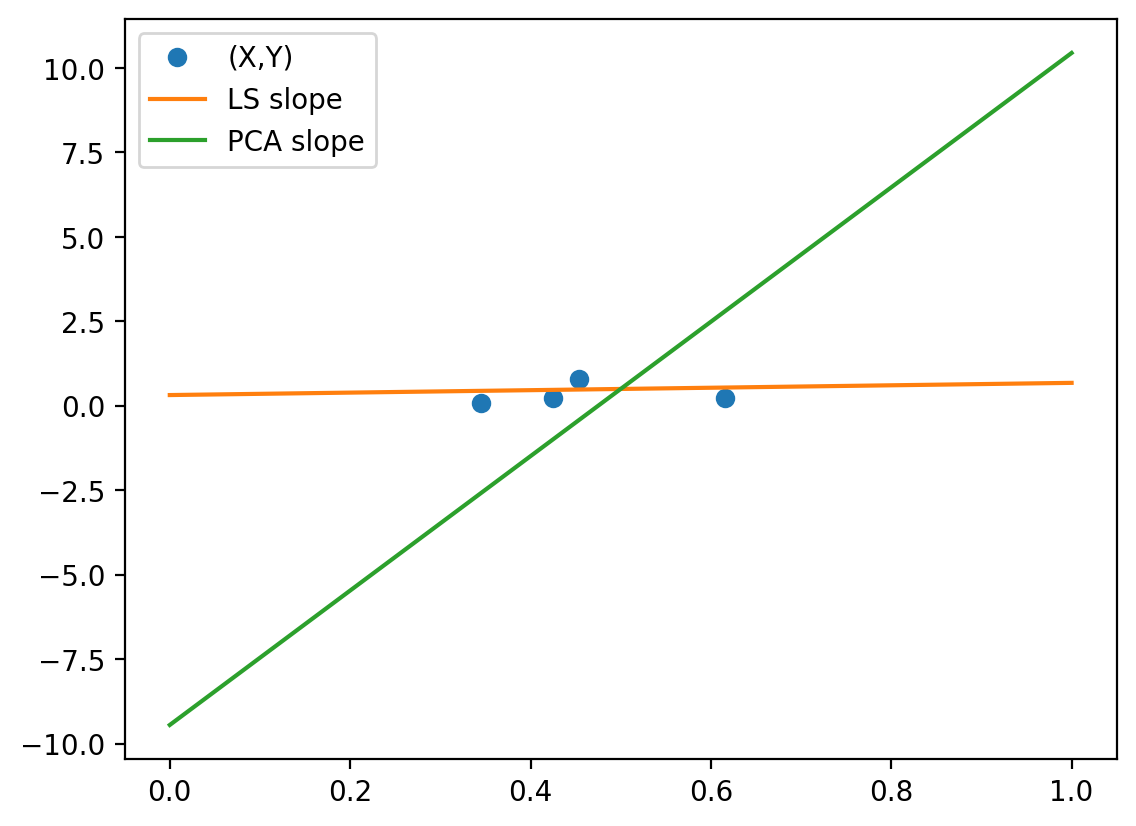

In [344]:
def one_b():
    X = np.random.uniform(0,1,size=4)
    Y = np.random.uniform(0,1,size=4)
    ls_slope = ls_recover(X, Y)
    pca_slope = pca_recover(X, Y)
    
    fig, ax = plt.subplots()
    ax.plot(X, Y, marker="o", linestyle="None", label="(X,Y)")
    ax.plot([0, 1], [.5-ls_slope/2, .5+ls_slope/2], label="LS slope")
    ax.plot([0, 1], [.5-pca_slope/2, .5+pca_slope/2], label="PCA slope")
    ax.legend(loc="best")
    
one_b()

<div class="custom-assignment-text">

(c) (5 points) We first consider the case where $x$ is an independent (a.k.a. explanatory) variable, and we get noisy measurements of $y$. Fix $X = [x_1, x_2,..., x_{1000}] = [.001, .002, .003,..., 1]$. For a given noise level $c$, let $\hat{y}_i ∼ 2x_i + \mathcal{N}(0, c) = 2i/1000 + \mathcal{N}(0, c)$, and $\hat{Y} = [\hat{y}_1, \hat{y}_2,..., \hat{y}_{1000}]$. Make a scatter plot with $c$ on the horizontal axis, and the output of pca-recover and ls-recover on the vertical axis. For each $c$ in $[0, 0.05, 0.1,..., .45, .5]$, take a sample $\hat{Y}$, plot the output of pca-recover as a red dot, and the output of ls-recover as a blue dot. Repeat 30 times. You should end up with a plot of 660 dots, in 11 columns of 60, half red and half blue.

Hint: in both numpy and matlab, $randn(1000)*σ$ generates an array of 1000 independent samples
from $\mathcal{N}(0, σ^2)$. In python you’ll also need to add `from numpy.random import randn`.

(d) (5 points) We now examine the case where our data consists of noisy estimates of both $x$ and $y$. For a given noise level $c$, let $\hat{x}_i ∼ x_i + \mathcal{N}(0, c) = i/1000 + \mathcal{N}(0, c)$ and $\hat{y}_i ∼ y_i + \mathcal{N}(0, c) = 2i/1000 + \mathcal{N}(0, c)$. Similar to (b), for each $c$ in $[0, 0.05, 0.1,..., .45, .5]$, take a sample $X_b$ and $Y_b$, plot the output of `pca_recover` as a red dot, and the output of `ls_recover` as a blue dot. Repeat 30 times. You should have a plot with 330 red dots and 330 blue dots.

</div>

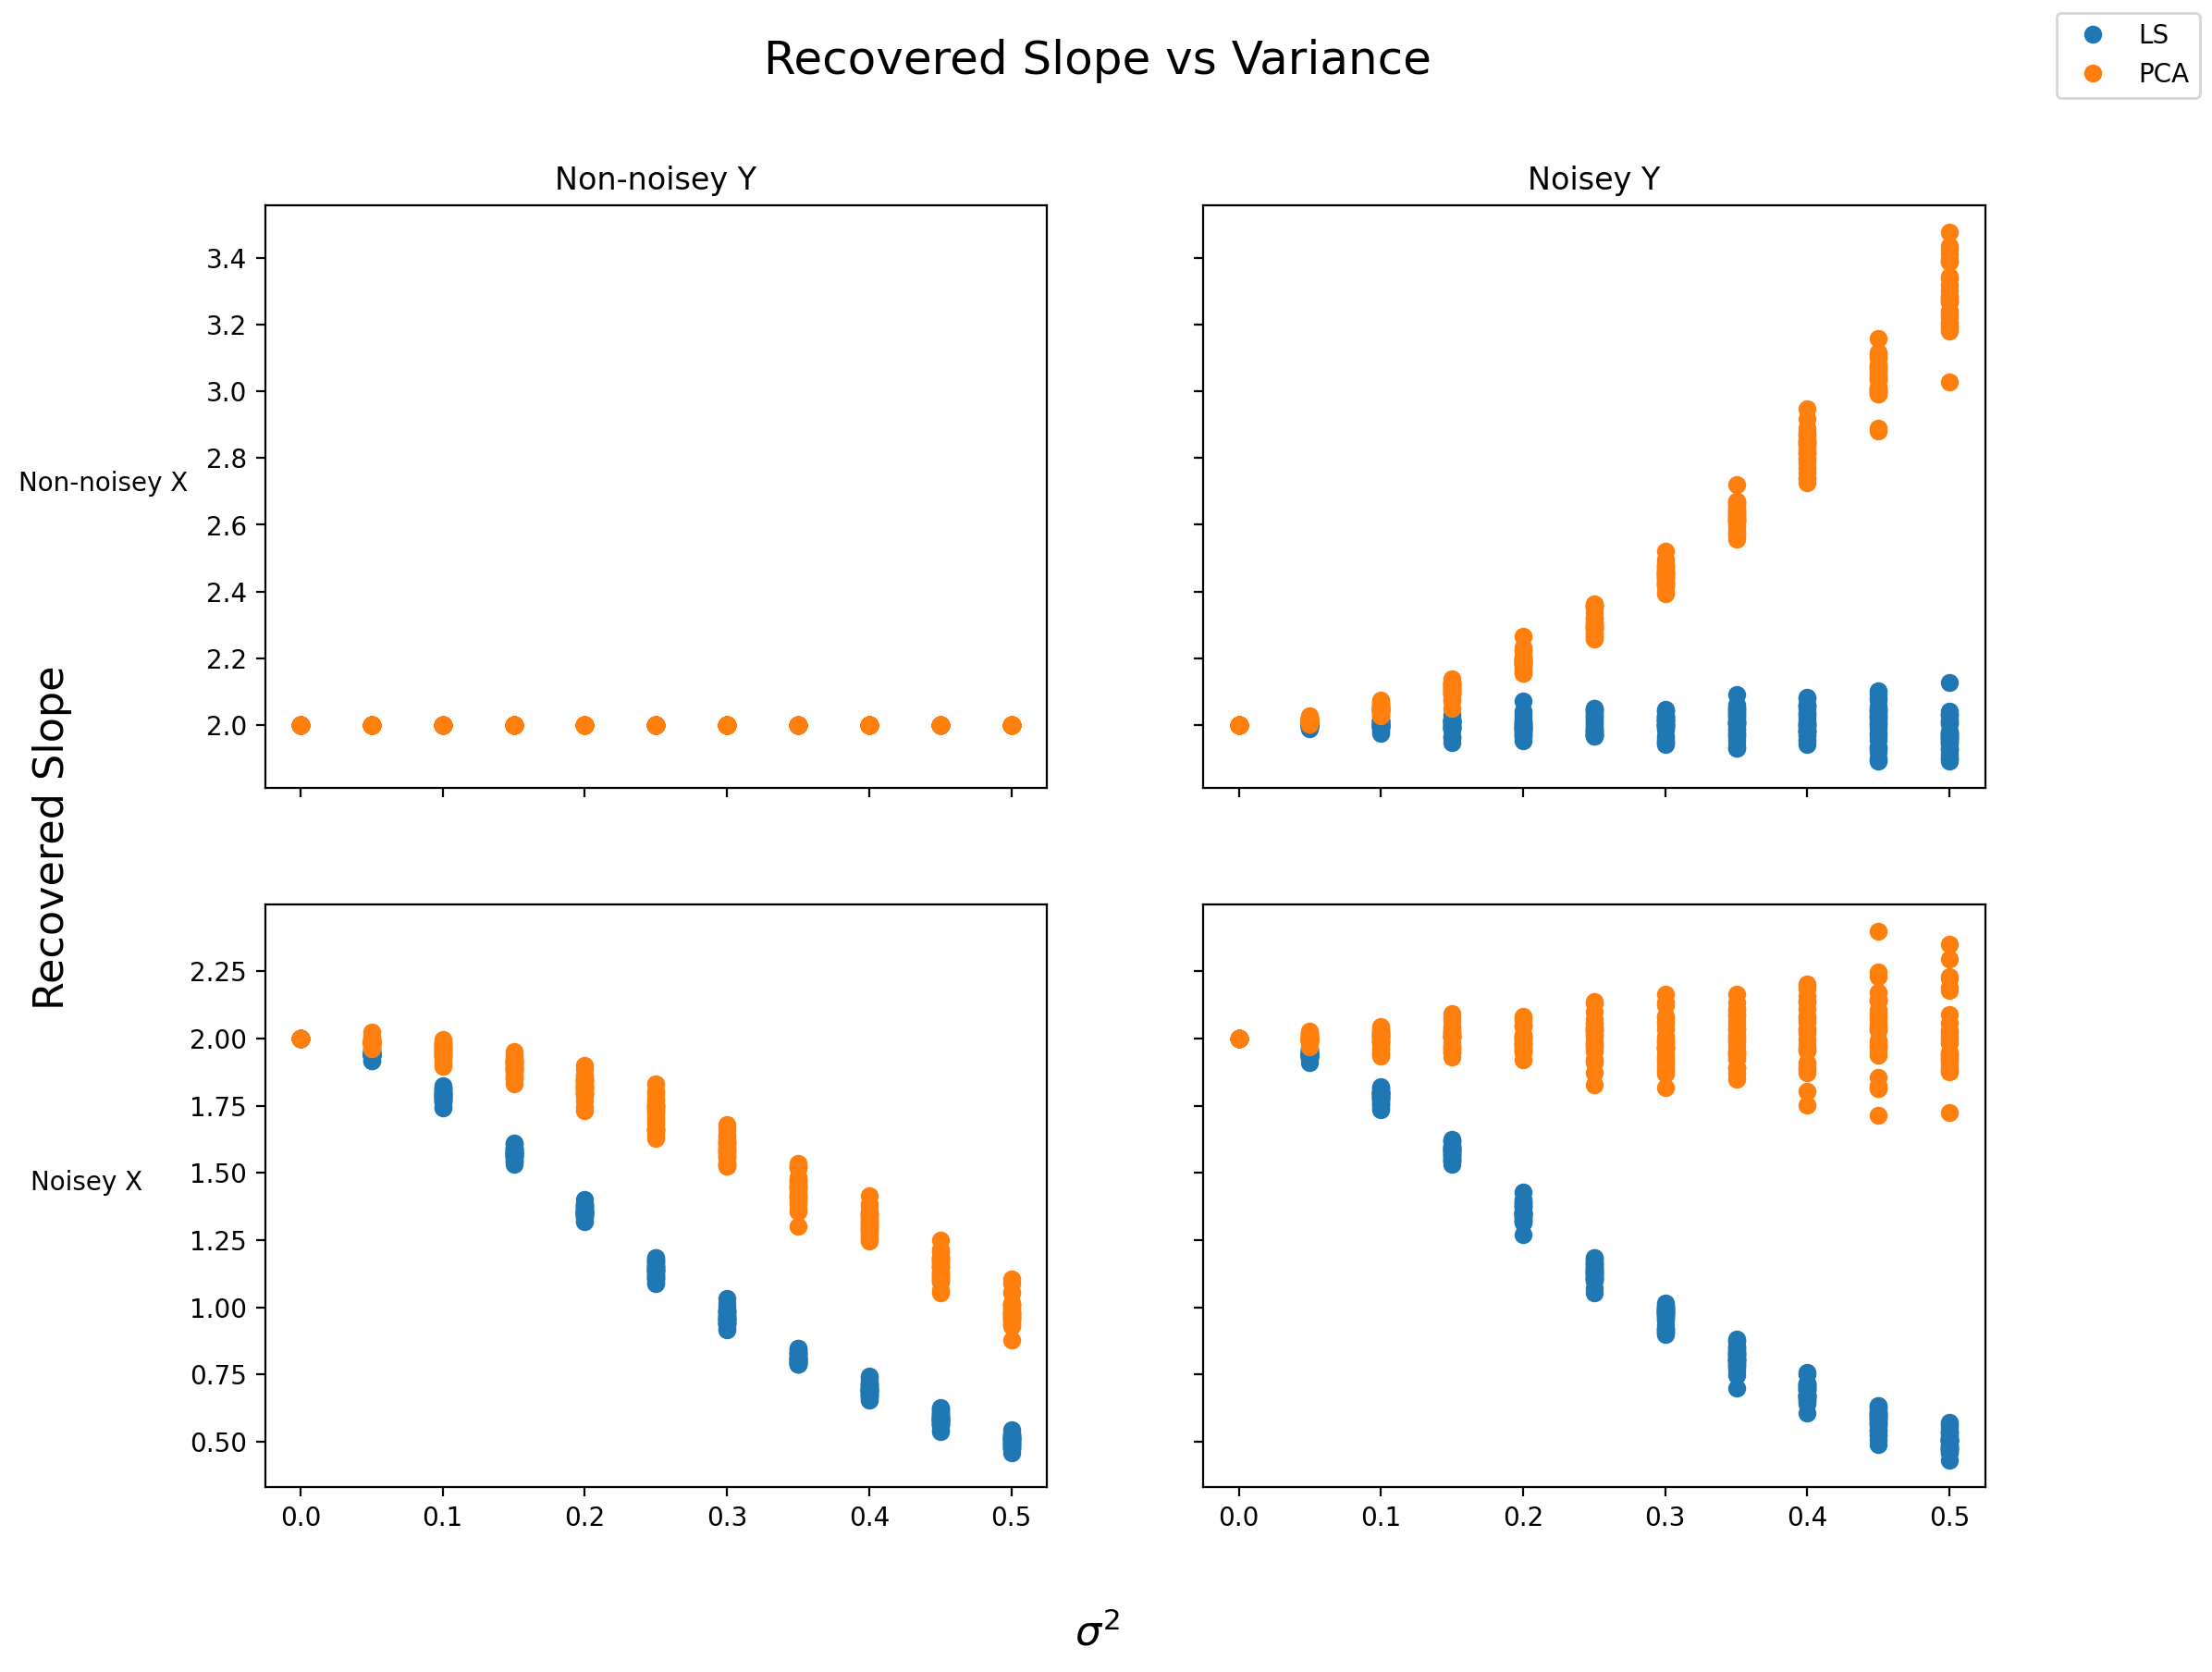

In [397]:
def recovery_experiment(c_vals, x_noisey, y_noisey, num_trials=30):
    ls_vals = []
    pca_vals = []
    for c in c_vals:
        for _ in range(num_trials):
            X = np.arange(.001, 1.001, .001)
            Y = 2 * X
            if x_noisey:
                X += randn(len(X)) * c
            if y_noisey:
                Y += randn(len(X)) * c

            ls_vals.append((c, ls_recover(X, Y)))
            pca_vals.append((c, pca_recover(X, Y)))
    return ls_vals, pca_vals

def graph_noise_vs_accuracy():
    c_vals = np.arange(0, 0.55, 0.05)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 9), sharex=True, sharey="row")
    for x_noisey in [True, False]:
        for y_noisey in [True, False]:
            ls_vals, pca_vals = recovery_experiment(c_vals, x_noisey, y_noisey)
            ax = axs[int(x_noisey), int(y_noisey)]
            ax.plot([x[0] for x in ls_vals], [x[1] for x in ls_vals], "o", label="LS", linestyle="None")
            ax.plot([x[0] for x in pca_vals], [x[1] for x in pca_vals], "o", label="PCA", linestyle="None")
            ax.set_ylabel("Noisey X" if x_noisey else "Non-noisey X", rotation=0, labelpad=40)
            if ax.get_subplotspec().is_first_row():
                ax.set_title("Noisey Y" if y_noisey else "Non-noisey Y")
    
            ax.label_outer()
        fig.supylabel("Recovered Slope", fontsize=16)
        fig.supxlabel("$\sigma^2$", fontsize=16)
    handles, labels = axs[1, 1].get_legend_handles_labels()
    fig.legend(handles, labels)
    fig.suptitle("Recovered Slope vs Variance", fontsize=18)
graph_noise_vs_accuracy()

<div class="custom-assignment-text">

(e) (9 points) Why does PCA do better in one, and least squares in the other? (No need to repeat the
discussion above about latent vs. known independent variables.) Split this into three questions: (i)
Why does PCA do poorly with noise in only $Y$? (ii) Why does PCA do well with noise in $X$ and $Y$?
(iii) Why does LS do poorly with noise in $X$ and $Y$?

</div>

(i) PCA seeks the line that explains variance in both $X$ and $Y$. When $Y$ has more variance to be captured, the slope of the line becomes steeper because PCA is finding a line that co-varies only with a wider range of $Y$ values.
(ii) With the variance in $X$ and $Y$ balanced, PCA's variance-finding leads to a slope which is balanced between the underlying $X$ and $Y$ values.
(iii) LS is designed to answer the question, "how much do we predict $Y$ to change on average given that we change $X$ by one unit?" This is done by fitting the equation $y_i = α + βx_i + \epsilon_i$, where $\epsilon_i$ is the residual (distance in the Y-axis from points to the fit line). If noise is added to $X$, then it becomes impossible to find a vector $β$ which produces a correlation with $Y$, and thus a bias towards 0 (meaning "no correlation") is produced.

Aside: This type of PCA-based regression is called [total least squares](https://en.wikipedia.org/wiki/Total_least_squares), and the bias caused in the ordinary least squares algorithm by variance in $X$ is called [regression dilution](https://en.wikipedia.org/wiki/Regression_dilution). 

Other sources that helped me understand the behavior of these algorithms:

* https://stats.stackexchange.com/questions/129991/why-doesnt-measurement-error-in-the-dependent-variable-bias-the-results
* https://web.stanford.edu/class/polisci100a/regress5.pdf

I wish that I could find a good geometric/visual explanation of why minimizing the distances only in the Y-axis leads to a bias towards 0 in LS. The conceptual explanations provided here will have to suffice for now.

<div class="custom-assignment-text">

# Part 2: Principal Component Analysis (PCA) of Genomes

## Goal
    
In this part of the mini-project, you will run PCA on a real data set, and interpret the output.

## Description
    
Download the `p4dataset2021.txt` file from the course Web site. The data represented there is from the [1000 genomes project](http://www.1000genomes.org/). Each of the 995 lines in the file represents an individual. The first three columns represent respectively the individual’s unique identifier, his/her sex (1=male, 2=female) and the population he or she belongs to. The subsequent 10,101 columns of each line are a subsample of nucleobases from the individual’s genome.

We will be looking at the output of PCA on this dataset. PCA can refer to a number of related things, so
to be explicit, in this section when we say “PCA” we mean
* The data should be centered (i.e., the sample mean subtracted out) but not normalized, so its alright
if some dimensions have different variance than other dimensions.
* The output should be the normalized principal components (i.e., unit-length eigenvectors).

Feel free to use a library implementation of PCA for the following questions. For python users, we recommend [scikit learn’s implementation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Matlab’s built-in pca function can also be used. Note that with both python scikit and Matlab, you can specify how many principal components you want (this can save on computation time).
    
## Exercises

First convert the data from the text file of nucleobases to a real-valued matrix (PCA needs a real-valued matrix). Specifically, convert the genetic data into a binary matrix $X$ such that $X_{i,j} = 0$ if the $i^{th}$ individual has column $j$’s mode nucleobase for his or her $j^{th}$ nucleobase, and $X_{i,j} = 1$ otherwise. Note that all mutations appear as a $1$, even if they are different mutations, so if the mode for column $j$ is “G”, then if an individual $i$ has an “A”,“T”, or “C”, then $X_{i,j}$ would be $1$.

The first 3 columns of the data file provide meta-data, and should be ignored when creating the binary
matrix X. We will examine genotypes to extract phenotype information.
    
</div>

In [34]:
from pandas._testing import assert_frame_equal
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from cs168.mini_project_4 import load_1000_genomes_data

In [126]:
IDS, SEXES, POPULATIONS, GENOMES = load_1000_genomes_data()

In [63]:
def get_mutations(genomes):
    """Convert the input `genomes` data into the binary matrix $X$ required by the assignment.
    That is, $X_{i,j}=0$ if the $i^{th}$ individual has column $j$'s mode nucleobase for their
    $j^{th}$ nucleobase, and 1 otherwise. In other words, we return a matrix $X$ which represents
    assumed mutations."""

    print("getting mode for each column...")
    mode = genomes.mode()
    rows = []
    print("determining mutations in each row...")
    for _, r in tqdm(genomes.iterrows(), total=genomes.shape[0]):
        rows.append((r != mode).astype(float))

    return pd.concat(rows, ignore_index=True)  # re-label rows with 0, 1, 2... n-1


def _test_get_mutations():
    # mode is ["a", "b", "c"]
    data = pd.DataFrame(
        [["a", "b", "c"], ["a", "B", "c"], ["a", "b", "c"], ["A", "b", "C"]]
    )
    mutations = get_mutations(data)
    assert_frame_equal(
        mutations,
        pd.DataFrame(
            [[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0], [1.0, 0.0, 1.0]]
        ),
    )
    ok()

_test_get_mutations()

getting mode for each column...
determining mutations in each row...


  0%|          | 0/4 [00:00<?, ?it/s]

In [71]:
MUTATIONS = get_mutations(GENOMES)

getting mode for each column...
determining mutations in each row...


  0%|          | 0/995 [00:00<?, ?it/s]

<div class="custom-assignment-text">

(a) (Warm-up, do not submit.) Say we ran PCA on the binary matrix X above. What would be the
dimension of the returned vectors?

</div>

I expect the return value to be a square matrix with dimension equal to the number of rows in the input ($10,101$ in this case). However, to limit computational cost we will use an incremental implementation from Scikit-Learn to only calculate the required number of greatest components.

<div class="custom-assignment-text">

(b) (6 points) We will examine the first 2 principal components of $X$. These components contain lots of
information about our data set. Create a scatter plot with each of the 995 rows of $X$ projected onto
the first two principal components. In other words, the horizontal axis should be $v_1$, the vertical axis $v_2$, and each individual should be projected onto the subspace spanned by $v_1$ and $v_2$. Your plot must use a different color for each population and include a legend.

</div>

In [157]:
# Scikit-Learn provides an incremental implementation, lowering computational costs
def pca_project(X, num_components=2):
    """Extract the specified number of principal components of X after normalizing;
    then return the projection of $X$ onto these components."""
    X_norm = StandardScaler().fit_transform(X)
    pca = decomposition.PCA(n_components=num_components)
    components = pd.DataFrame(pca.fit_transform(X_norm.T))
    projections = X.dot(components)
    
    assert projections.shape == (X.shape[0], num_components)
    return projections

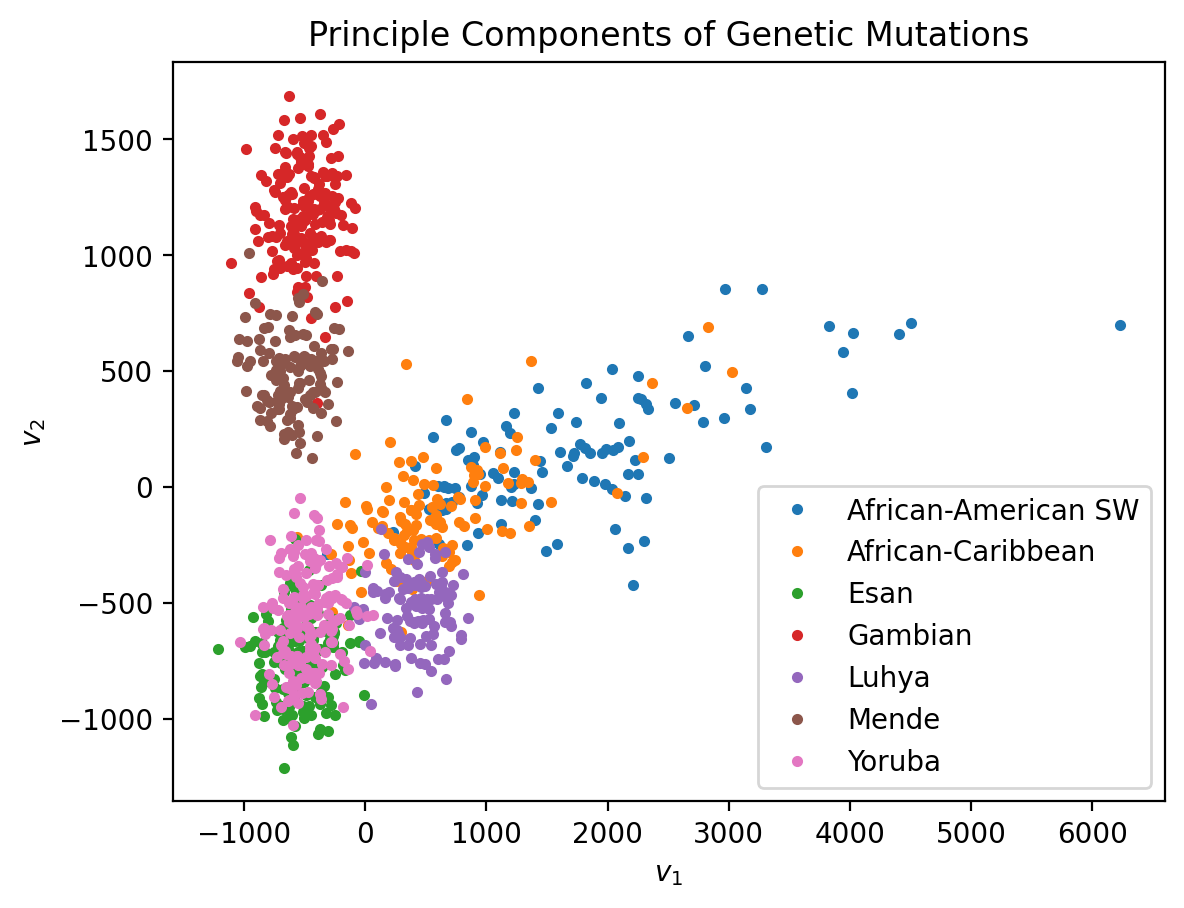

In [158]:
def plot_mutation_principle_components_1_2():
    projections = pca_project(MUTATIONS, num_components=2)
    assert projections.shape == (995, 2)
    
    fig, ax = plt.subplots()
    ax.set_xlabel("$v_1$")
    ax.set_ylabel("$v_2$")
    ax.set_title("Principle Components of Genetic Mutations")
    for label in sorted(POPULATIONS.unique()):
        mask = POPULATIONS == label
        ax.plot(projections.loc[mask, 0], projections.loc[mask, 1], ".", label=label)
    ax.legend(loc="best")
    
plot_mutation_principle_components_1_2()

<div class="custom-assignment-text">

(c) (7 points) In two sentences, list 1 or 2 basic facts about the plot created in part (b). Can you interpret the first two principal components? What aspects of the data do the first two principal components capture? Hint: think about history and geography.

</div>

The plot most clearly reflects geographic distribution. Yoruba and Esan are from around Nigeria, and Gambian and Mende are from further to the west (the Mende are from Sierra Leone). The Luhya are from East Africa, and African-Caribbean and African-American are related diasporas. I'm uncertain how to interpret the overlap between African-Caribbean and Luhya, since geographically they seem to be the most unrelated. At least they do appear to cluster distinctly.

<div class="custom-assignment-text">

(d) (5 points) We will now examine the third principal component of $X$. Create another scatter plot with each individual projected onto the subspace spanned by the first and third principal components. After plotting, play with different labeling schemes (with labels derived from the meta-data) to explain the clusters that you see. Your plot must include a legend.

</div>

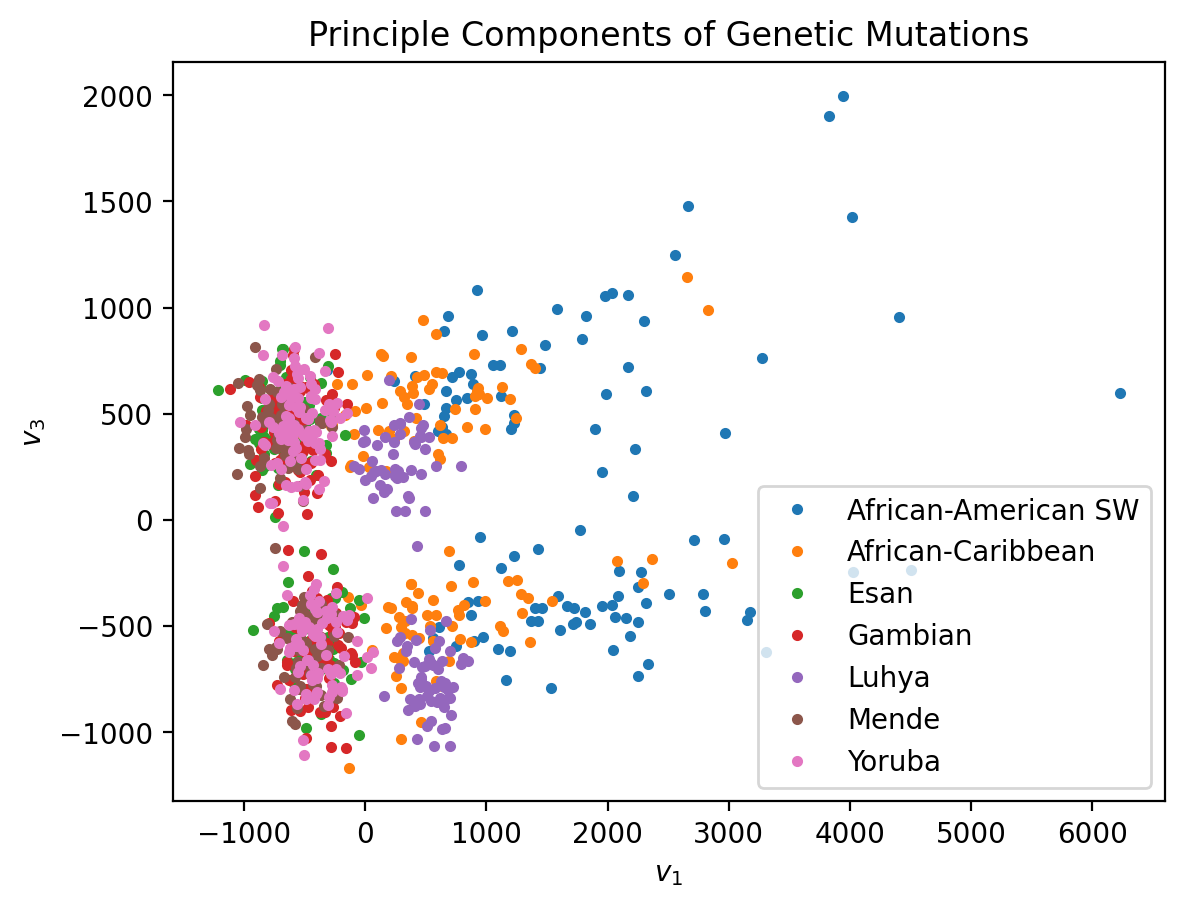

In [159]:
def plot_mutation_principle_components_1_3():
    projections = pca_project(MUTATIONS, num_components=3)
    assert projections.shape == (995, 3)
    
    fig, ax = plt.subplots()
    ax.set_xlabel("$v_1$")
    ax.set_ylabel("$v_3$")
    ax.set_title("Principle Components of Genetic Mutations")
    for label in sorted(POPULATIONS.unique()):
        mask = POPULATIONS == label
        ax.plot(projections.loc[mask, 0], projections.loc[mask, 2], ".", label=label)
    ax.legend(loc="best")
    
plot_mutation_principle_components_1_3()

<div class="custom-assignment-text">

(e) (5 points) Something should have popped out at you in the plot above. In one sentence, what  information does the third principal component capture?

</div>

Since the plot appears to split cleanly into two categories, each reflecting geography within itself, I believe it reflects the sex of the individuals. (I cannot find specific documentation saying that the Y chromosome was used in the study; I had thought that it would be excluded).

<div class="custom-assignment-text">

(f) (4 points) In this part, you will inspect the third principal component. Plot the nucleobase index vs the absolute value of the third principal component. What do you notice? What’s a possible explanation?
Hint: think about chromosomes (and if you don’t know much biology, feel free to look through the
wikipedia page on chromosomes....)

</div>

<div class="custom-assignment-text">

(g) For this problem we simplified our dataset by capturing all deviations from the mode value with an
indicator variable. This loses some information relative to the original data set. How would you create
a real-valued matrix $Y$ suitable for PCA analysis such that there is a bijection between our input data
(minus the first three columns) and $Y$? The matrix $Y$ should be a useful input to PCA. Explain the
reasoning behind your choice of $Y$ . Your answer to this question should not take more than a few
sentences

</div>

<div class="custom-assignment-text">

(h) Perform PCA on the matrix $Y$ from part (g). Recreate the plot from part (b). What added value (if
any) does this more complex representation add?

</div>

<div class="custom-assignment-text">

(i) Can you uncover what information is captured in the fourth principal component of $X$?

</div>

<div class="custom-assignment-text">

(j) The provided dataset represents approximately 0.6% of the dataset found at the top of this directory:
http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/supporting/hd_genotype_chip/. What other information can you uncover from this much larger file? For this question we encourage you to look at populations beyond Africa. You will notice that the file is a compressed .vcf file, you may want to look into installing vcftools to work with the file.

</div>